<h1 style="text-align: center; vertical-align: middle;">Numerical Methods of Accelerator Physics</h1>
<h2 style="text-align: center; vertical-align: middle;">Lecture Series by Dr. Adrian Oeftiger</h2>

<h3 style="text-align: center; vertical-align: middle; margin-top: 1em; margin-bottom: 1em;">Guest Lecture by Dr. Andrea Santamaria Garcia</h3>

<div style="width: 45%; margin: auto; vertical-align: middle; ">
<img src="./img/etit.png" style="width: 40%; float: left; vertical-align: center" /><img src="./img/KIT_logo.svg" style="width: 38%; float: right; vertical-align: center;" />
</div>
<div style="clear: both; vertical-align: middle;"></div>

<h3 style="text-align: center; vertical-align: middle; ">Part 14: 10.02.2023</h3>

<h2>Run this notebook online!</h2>

Interact and run this jupyter notebook online:

<div class="alert alert-block alert-info" style="text-align:center;">
1. via the public mybinder.org service: <br />

<p style="text-align: center; margin-left, margin-right: auto; width: 100%;">
<a href="https://mybinder.org/v2/gh/aoeftiger/TUDa-NMAP-14/v1.0"><img src="./img/binder_logo.svg" /></a>
</p>
</div>

<div class="alert alert-block alert-success" style="text-align:center;">
2. on the <a href="https://tu-jupyter-i.ca.hrz.tu-darmstadt.de/">local TU Darmstadt jupyterhub $\nearrow$</a> (using your TU ID)

$\implies$ make sure you installed all the required python packages (see the [README](./README.md))!
</div>

Finally, also find this lecture rendered [as HTML slides on github $\nearrow$](https://aoeftiger.github.io/TUDa-NMAP-14/) along with the [source repository $\nearrow$](https://github.com/aoeftiger/TUDa-NMAP-14).

<h2>Run this first!</h2>

Imports and modules:

In [1]:
from config import (np, plt)
from scipy.constants import m_p, e, c
# %matplotlib inline

<h2 style="color: #b51f2a">Refresher!</h2>

- ...

<h2 style="color: #b51f2a">Today!</h2>

1. Bayesian Optimisation
2. XYZ

<div style="text-align: center; width:100%;">
    <h2>Part I: Bayesian Optimisation</h2>
</div>

In this tutorial notebook we'll implement all the basic components of Bayesian optimization (BO), and see how to use BO for some sample functions.

## 0. Glossary and General Introduction

### 0.1 Bayes' Theorem

First, let's start with the absolute basics of Bayesian inference, the Bayes' theorem
    $$P(A|B) = \frac{P(B|A)P(A)}{P(B)}$$

- $P(A|B)$ is the _posterior probablity_ of event $A$ given that event B is observed.
- $P(B|A)$ is the _likelihood function_ of A given B; it is also the conditional probablity of observing $B$ given $A$.
- $P(A), P(B)$ are the _prior probabilities_ of observing $A$ and $B$, also known as _marginal probability_

For most applications, the observed event $B$ is already fixed and we can consider $P(B)$ simply as a constant. Thus the Bayes' theorem reads
    $$P(A|B) \propto P(B|A) P(A) $$,
i.e. the __posterior probability__ is proportional to __priors__ times __likelihood__.

### 0.2 Gaussian Process

A Gaussian process (GP) is a stochastic process (a joint distribution of infinitely many random variables), which can be used as a probablistic model (surrogate model) for the objective function in regression and classification tasks.

A GP can be fully described by it's mean $\mu$ and covariance function $k(\cdot,\cdot)$
    $$f(x) \sim \mathcal{GP}(\mu(x), k(x,x'))$$,
where $x$ and $x'$ are points in the input space. 

- __Gaussian process regression (GPR)__, also formerly known as _kriging_: a method to interpolate a unkown objective function.
- __Prior mean__ $\mu(x)$: basic building block of GP; prior belief on the averaged objective function values, usually set to a constant if the function behaivor is unknown.
- __Kernel__ $k(\cdot,\cdot)$, also known as the _covariance function_ $cov(\cdot,\cdot)$: basic building block of GP; prior belief on the characteristics of the unkown function.

_Note: in GP regression, one usually understands $x'$ as the observed points, and $x$ as the continous variable_

#### 0.2.1 Common Kernels used in GP

Some of the commonly used kernels are listed below. They can also be combined to build more complex kernels representing the underlying physics of the objective function.

For simplicity reason, we define $d_{x,x'}$ as the Euclidean distance between the two points
    $$ d_{x,x'} := ||x - x'||_2 $$

- Linear: $k_\mathrm{L}(x,x') = x^\intercal x'$. A special case that one might not often use (non-stationary kernel), this reduces GP essentially back to Bayesian linear regression.
- __White Gaussian noise__: $k_\mathrm{n}(x,x')=\sigma_{n}^2 \delta_{x,x'}$ , i.e. a diagnal noise term with Gaussian noise $\sigma_{n}^2$.
- __Radial basis function (RBF)__, also known as squared exponential (SE): $k_{\mathrm{RBF}} (x,x') = \exp(-\frac{d_{x,x'}^2}{2 l^2})$ , where $l$ is the lengthscale, see below. This resembles a normal Gaussian distribution. It is more or less _the default_ choice of kernel for GPs if one does not have a special assumption on the objective function.
- Rational quadratic (RQ): $k_\mathrm{RQ}=\left( 1 + \frac{d_{x,x'}}{2\alpha l^2} \right)^{-\alpha}$, equivalent of sum of RBF kernels with many different lengthscales. Approaches RBF when $\alpha \to \infty$
- Matérn: $k_\mathrm{Matern} (x,x') = \frac{2^{1-\nu}}{\Gamma(\nu)} \left( \sqrt{2\nu d_{x,x'}} / l \right)^\nu K_\nu \left( \sqrt{2\nu d_{x,x'}} / l \right) $, where $\Gamma$ is the gamma function, $K_\nu$ the modified Bessel function and $\nu$ the parameter of the Matérn kernel. Common choices are $\nu=\frac{3}{2},\frac{5}{2},...$ for once and twice differentiable functions.
- Ornstein-Uhlenbeck: $k_\mathrm{OU}(x,x')=\exp(-d_{x,x'}/l)$


#### 0.2.2 GP Hyperparamters 

The characteristics of GP, or its ability to approximate the unknown function are dependent both on __the choice of the covariance function__ and the __values of the hyperparamters__. The hyperparamters are usually either choosen manually based on the physics, or obtained from the maximum likelihood fit (log-likelihood fit, maximum a posteriori fit) during the optimization.

- __Lengthscale__ $l$: controls the scaling of different input dimensions, i.e. how fast the objective function is expected to change from observed points.
- __Noise variance__  $\sigma_\mathrm{n}^2$: magnitude of the noise in the observed values.
- __Signal variance__ $\sigma^2$: a scaling factor to be multiplied to the kernel function, it is essentially equivalent to normalize/scale the objective function.


### 0.3 Bayesian Optimization

Bayesian optimization is a sequential algorithm to globally optimize an unknown function.

Below are some common terms used in the BO field, some of which are often used interchangeably.

- __Acquisition function__ $\alpha$: is built on the GP posterior, controls the behavior of optimization. For the standard verison of BO, the next sample point is chosen at $\mathrm{argmax}(x)$. In this tutorial we will introduce two widely used acquisition functions: the expected improvment (EI) and the upper confidence bound (UCB).
- __Objective__, metric, or target function: a unknown (black-box) function, for which the value is to be optimized (here: maximization).
- __Search space__, bounds, or optimization range: A (continous) parameter space where the input parameters are allowed to be varied in the optimization.

<h2>An Image</h2>

<img src="img/some-image.png" alt="what's inside the image" style="width: 80%; margin: auto;" />

<p style="clear: both; font-size: 10pt; text-align: right; float: right;">image by <a href="https://google.me/">XYZ</a></p>

<h2>Something</h2>

(...)

<h2>Summary</h2>

- ... all contents as relevant for the exam

In [2]:
from gpytorch.models import ExactGP
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.kernels import RBFKernel, MaternKernel, ScaleKernel
from botorch.models import SingleTaskGP
import numpy as np
import botorch
import gpytorch
import torch
from matplotlib import pyplot as plt
from typing import Union, Optional
import warnings
warnings.filterwarnings('ignore')

### Refresher: Gaussian Process

First, let's define a test function

$$ y = \sin (2 \pi x) + \epsilon$$

In [3]:
# Set Random seed for reproducibility
random_seed = 3
rng = torch.random.manual_seed(random_seed)

# Setup our test function
xmin, xmax = 0, 1
n_train_x = 10
train_x = torch.rand(n_train_x,1, generator=rng) * (xmax - xmin) + xmin
# train_x = torch.linspace(xmin,xmax,15).reshape(-1,1)
train_y = (torch.sin(train_x * 2 * np.pi) + torch.randn(size=train_x.size(), generator=rng) * 0.2)
fine_x = torch.linspace(xmin,xmax,200).reshape(-1,1)
fine_y = torch.sin(fine_x * 2 * np.pi)
test_X = torch.linspace(xmin,xmax,200)

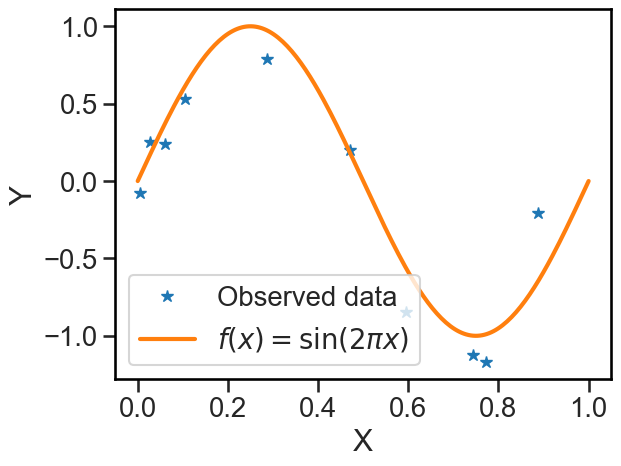

In [4]:
plt.plot(train_x, train_y, "*", label="Observed data")
plt.plot(fine_x, fine_y, label=r"$f(x)=\sin(2\pi x)$")

plt.xlabel("X")
plt.ylabel("Y")
plt.legend()

### TODO: Clean-up the plotting utils and imports to seperate function

In [5]:
def sample_gp_prior_plot(model: Union[ExactGP,SingleTaskGP], n_samples: int=5, ax=None, y_lim: Optional[tuple]=None):
    with gpytorch.settings.prior_mode(True):
        model.eval()
        preds = model(test_X)

    # Plotting
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot()
    prior_mean = preds.mean.detach().numpy()
    prior_std = preds.stddev.detach().numpy()
    ax.plot(test_X, prior_mean)
    ax.fill_between(test_X, prior_mean-2*prior_std, prior_mean+2*prior_std, alpha=0.2)
    for i in range(n_samples):
        y_sample = preds.sample();
        ax.plot(test_X, y_sample,ls=":")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_title("Samples drawn from the prior GP model")
    if y_lim is not None:
        ax.set_ylim(y_lim)
    return ax

In [6]:
def sample_gp_posterior_plot(model: Union[ExactGP,SingleTaskGP], n_samples: int=5, ax=None, y_lim: Optional[tuple]=None, show_true_f: bool=False, true_f_x=None, true_f_y=None):
    with gpytorch.settings.prior_mode(False):
        model.eval()
        preds = model(test_X)

    # Plotting
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot()
    prior_mean = preds.mean.detach().numpy()
    prior_std = preds.stddev.detach().numpy()
    ax.plot(test_X, prior_mean,label="GP mean")
    ax.fill_between(test_X, prior_mean-2*prior_std, prior_mean+2*prior_std, alpha=0.2, label=r"2$\sigma$ confidence bound")
    for i in range(n_samples):
        y_sample = preds.sample();
        ax.plot(test_X, y_sample,ls=":")
    # Add observed data
    ax.plot(model.train_inputs[0].flatten(), model.train_targets, color='black', ls="", marker="*",label='Data points')
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_title("GP Posterior")
    if y_lim is not None:
        ax.set_ylim(y_lim)
    ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    return ax

For the covariance function (kernel), we choose a scaled radial basis function (RBF) kernel
$$K_\text{Scaled-RBF} (\bm{x_1},\bm{x_2})= \theta_\text{scale} \exp\left( - \frac{1}{2}(\bm{x_1} - \bm{x_2})^\top \Sigma^{-2} (\bm{x_1} - \bm{x_2}) \right),$$

where $\theta_\text{scale}$ is the _outputscale_ parameter, $\Sigma^{2}$ is the covariance matrix; In simple case, the _lengthscales_ for each input dimension are just the diagonal terms.

c.f. [GPyTorch documentation](https://docs.gpytorch.ai/en/v1.6.0/kernels.html) for more details

In [7]:
# define the kernel
kernel = ScaleKernel(RBFKernel())
# Build the GP model
model = SingleTaskGP(train_X=train_x, train_Y=train_y, covar_module=kernel)  
# You can change the GP hyperparameters here
model.covar_module.base_kernel.lengthscale = 0.2
model.covar_module.outputscale = 1
model.likelihood.noise_covar.noise = 0.1

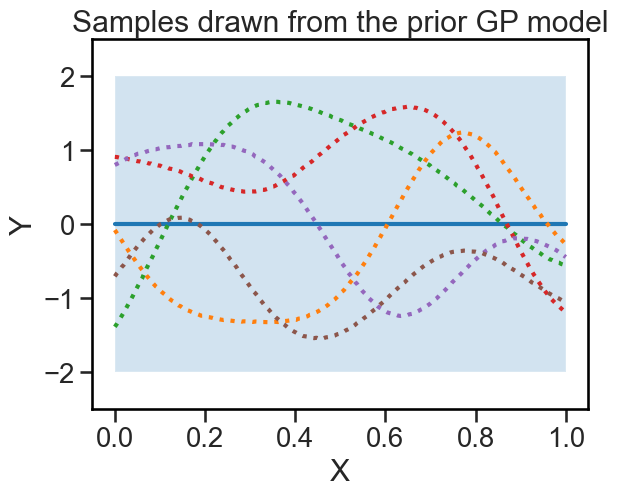

In [8]:
ax = sample_gp_prior_plot(model)
ax.set_ylim(-2.5,2.5);

<AxesSubplot: title={'center': 'GP Posterior'}, xlabel='X', ylabel='Y'>

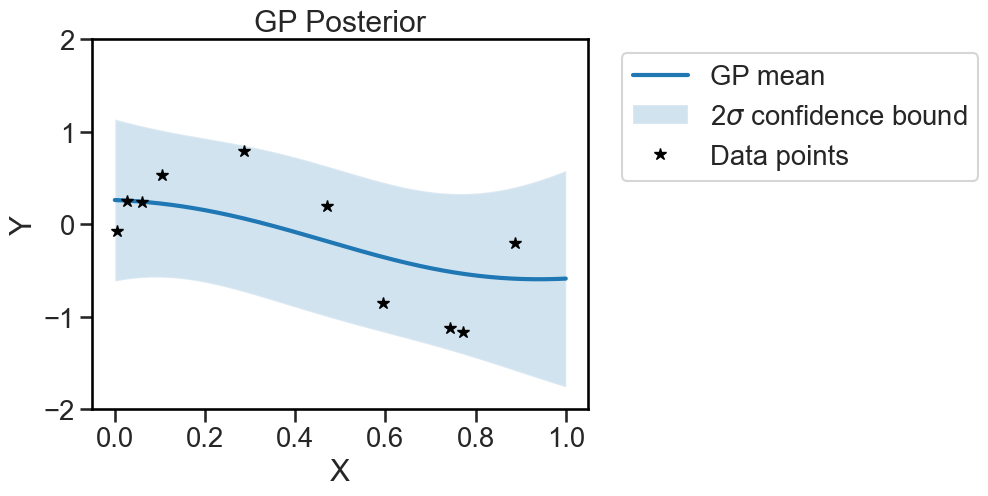

In [9]:
kernel = ScaleKernel(RBFKernel())
model = SingleTaskGP(train_X=train_x, train_Y=train_y, covar_module=kernel)
#################################################################################
### Modify the values below so that GP model properly fits the unknown function
model.covar_module.base_kernel.lengthscale = 0.5
model.covar_module.outputscale = 1
model.likelihood.noise_covar.noise = 1
#################################################################################

# Show the GP posterior with observed data points
sample_gp_posterior_plot(model, y_lim=(-2,2), n_samples=0)
# You can now increase the `n_samples` here to show some functions sampled from the GP posterior

### Set the hyperparameters properly

One can use __prior knowledge__ (experience, archive data, ...) to constrain or even fix the GP hyperparameters.

Another approach is to dynamically __adapt / fit__ the hyperparameters to the data.

In BoTorch there is a convenient helper function [`fit_gpytorch_mll`](https://botorch.org/api/fit.html#botorch.fit) to fit the GP model to the data using _marginal log-likelihood_ fits.

In [10]:
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_mll

<AxesSubplot: title={'center': 'GP Posterior'}, xlabel='X', ylabel='Y'>

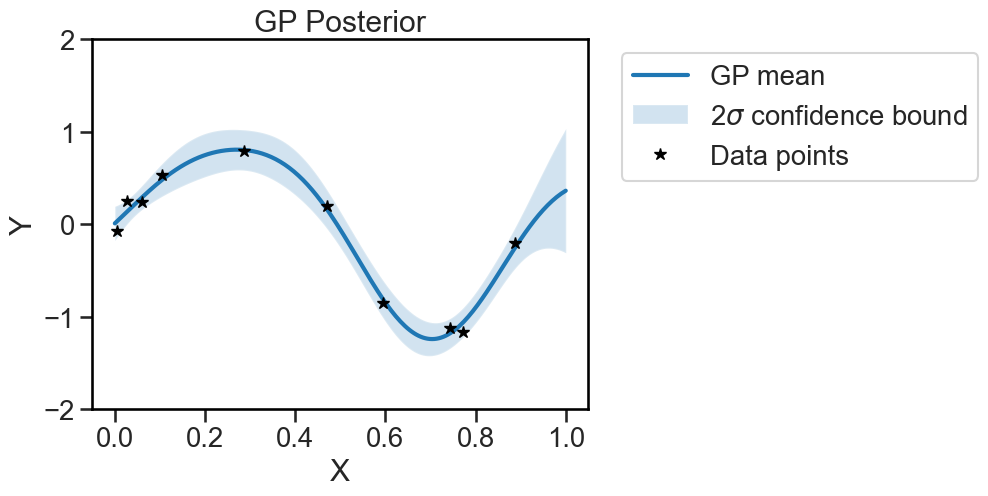

In [11]:
# Define the GP model again
kernel = ScaleKernel(RBFKernel())
model = SingleTaskGP(train_X=train_x, train_Y=train_y, covar_module=kernel)
# Define the likelihood
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_mll(mll)

# Show the results
sample_gp_posterior_plot(model, y_lim=(-2,2), n_samples=0)
# Now the GP model should nicely fit to the data

### Build an acquisition function

In BO, one uses an acquisition function to measure how interesting it would be to sample the function $f$ at a point $x$. 

The acquisition function $\alpha$ is built based on the GP posterior, e.g. a probablistic surrogate model of the underlying function.

BoTorch has implemented a variety of common acquisition functions, see [documentation](https://botorch.org/api/acquisition.html). 

In this tutorial we will use the __Upper Confidence Bound (UCB)__ function.

$$ \alpha_\text{UCB} = \mu (x) + \sqrt{\beta} \sigma(x),$$

where $\mu$ and $\sigma$ are the GP posterior mean and standard deviation respectively. $\beta$ is an hyperparameter controlling the _exploration-exploitation trade-off_.

In [12]:
from botorch.acquisition import UpperConfidenceBound, ExpectedImprovement, ProbabilityOfImprovement

In [13]:
# TODO: Move the plotting func to utils
def plot_acq_with_gp(model, train_x, train_y, acq, test_X):
    test_acq_values = acq(test_X.reshape(-1,1,1)).detach().numpy()
    preds_mean = model(test_X).mean.detach().numpy()
    preds_sigma = model(test_X).stddev.detach().numpy()
    plt.plot(test_X, preds_mean, label="GP mean")
    plt.fill_between(test_X,preds_mean-2*preds_sigma,preds_mean+2*preds_sigma,alpha=0.3,label=r"$2\sigma$ confidence")
    plt.plot(train_x,train_y,ls="",marker="*",color="black",label="Data points")
    plt.plot(test_X, test_acq_values, label="UCB acq")
    x_next = test_X[np.argmax(test_acq_values)]
    y_next = test_acq_values.max()
    plt.plot(x_next,y_next, ls="", marker="o", label="max(acq)")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

In [14]:
# Feel free to change the beta value in UCB, or use other acquistion functions
acq = UpperConfidenceBound(model, beta=4)
# acq = ExpectedImprovement(model,best_f=float(model.train_targets.max()))
# acq = ProbabilityOfImprovement(model, best_f=float(model.train_targets.max()))

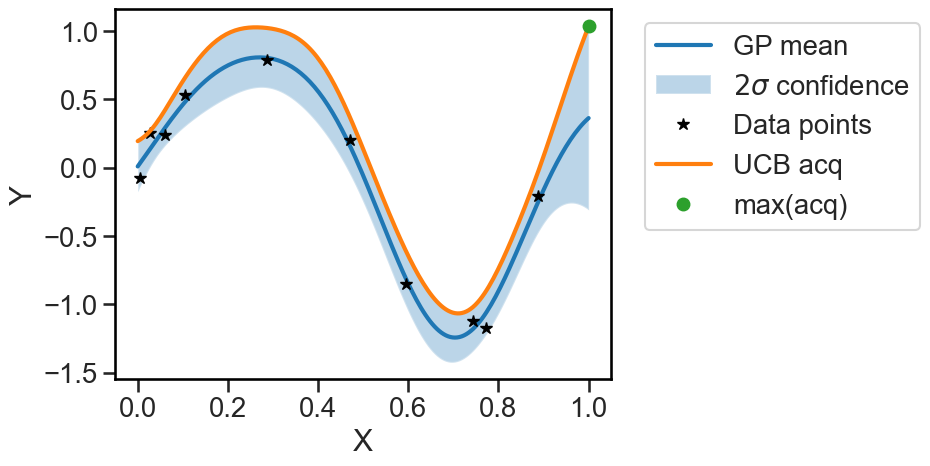

In [15]:
plot_acq_with_gp(model, train_x, train_y, acq, test_X)

___

<div style="text-align: center; width:100%;">
    <h2>Part II: BO for Beam Positioning and Focusing at Linac</h2>
</div>

Add Slides for ARESEA Problem

In [16]:
from ares_ea.env import ARESEA
from gym.wrappers import RescaleAction
import time
from IPython.display import clear_output, display

### Look at the ARESEA Gym environment

In [17]:
# Create the environment
env = ARESEA()

# Wrap the environment with some utilities:
env = RescaleAction(env, -1, 1)  # Normalize the action space to [-1,1]^n
env.reset()


({'magnets': array([0., 0., 0., 0., 0.]),
  'target_beam': array([-0.00017994,  0.00061451, -0.00044714,  0.00069763], dtype=float32),
  'current_beam': array([0.        , 0.00010026, 0.        , 0.00010026], dtype=float32)},
 {})

#### Exercise 2.0: Get familiar with the Gym environment

What you can do now:

- Apply some manual actions to move the beam
- Visualize the env `env.render()`

In [18]:
env.target_beam

array([-0.00017994,  0.00061451, -0.00044714,  0.00069763], dtype=float32)

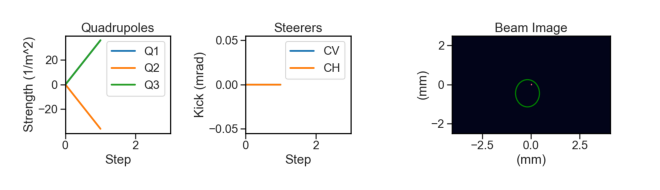

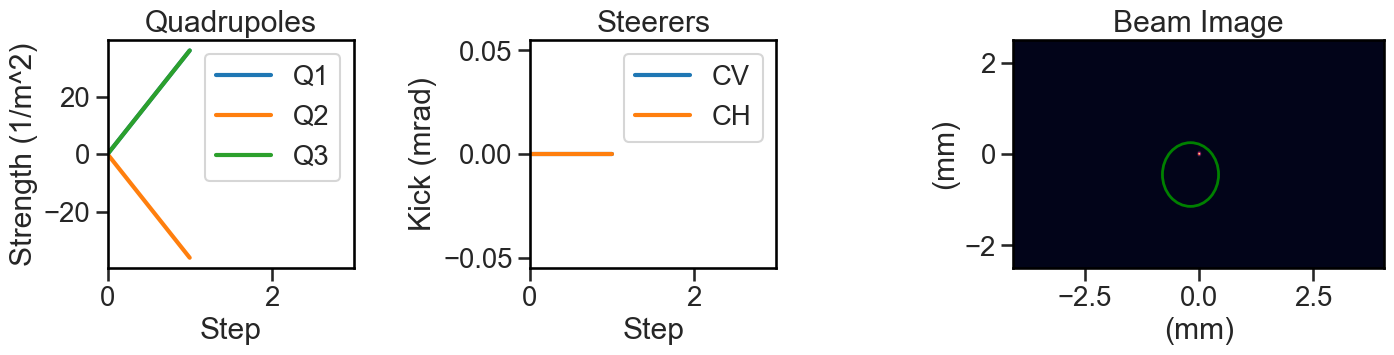

In [19]:
action = np.array([0,0,0,0,0])  # put your action here
observation, reward, done, info = env.step(action)  # Perform one step: update the env, observe new beam!

# Plotting
fig = plt.figure()
ax = plt.Axes(fig, [0.0, 0.0, 1.0, 1.0])
ax.set_axis_off()
fig.add_axes(ax)
img = env.render(mode="rgb_array")
ax.imshow(img)

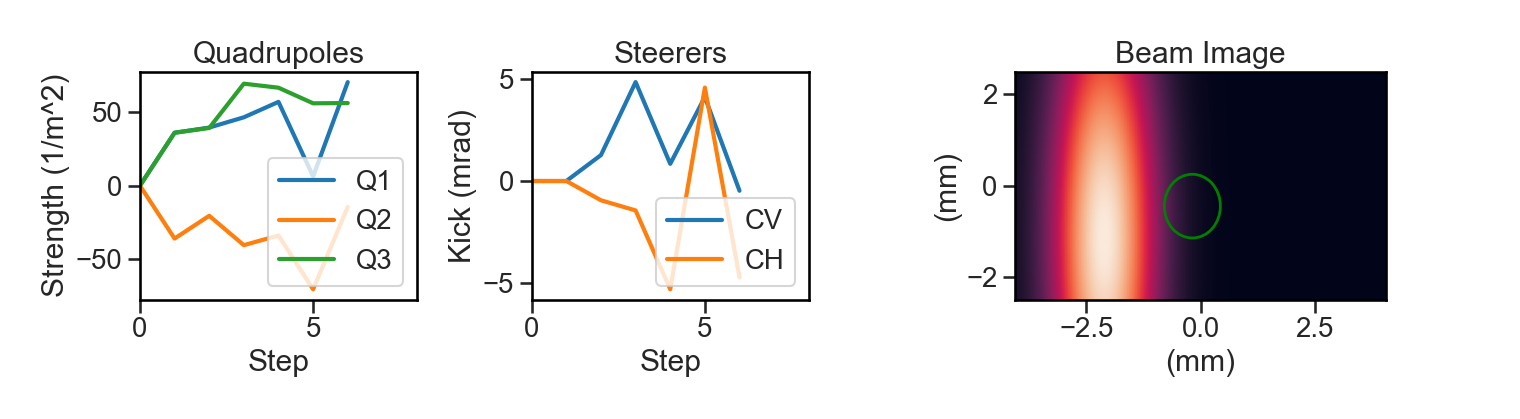

In [20]:
fig = plt.figure()
fig.set_size_inches(15,4)
ax = plt.Axes(fig, [0.0, 0.0, 1.0, 1.0])
ax.set_axis_off()
fig.add_axes(ax)
for i in range(5):
    env.step(np.random.random(5)*2-1)  # Choose your favorite action here!
    img = env.render(mode="rgb_array")
    ax.imshow(img)
    display(fig)
    clear_output(wait=True)
    time.sleep(0.5)

### Implement a full BO loop

In [21]:
from botorch.optim import optimize_acqf
from botorch.models.transforms import Standardize
from gym.spaces.utils import unflatten
import gym
from ares_ea.bo_utils import ProximalAcquisitionFunction

In [22]:
def bayesian_optimize(env: gym.Env, last_observation, init_mode="current", n_steps=50, acquisition="UCB", beta=2, n_init=3, max_step_size:float=0.5, set_to_best=True, random_seed=None, show_plot=False, proximal=None):
    ##################################################################
    # Some preliminary settings
    if random_seed is None:
        random_seed = torch.random.seed() # random
    rng = torch.random.manual_seed(random_seed)

    # Initialization: some initial samples are needed to build a GP model

    # First sample from the reset observation
    initial_action = scale_action(env, last_observation)

    if init_mode=="current":
        X = torch.tensor([initial_action]).reshape(1,-1)
        while len(X)<n_init:
            last_action = X[0].detach().numpy()
            bounds = get_new_bound(env, last_action, max_step_size)
            new_action = np.random.uniform(low=bounds[0], high=bounds[1])
            new_action_tensor = torch.tensor(new_action, dtype=torch.double).reshape(
                1, -1
            )
            X = torch.cat([X,new_action_tensor])
    else:  # sample purely randomly
        X = torch.tensor([], dtype=torch.double)
        while len(X)<n_init:
            new_action = env.action_space.sample()
            new_action_tensor = torch.tensor(new_action, dtype=torch.double).reshape(
                1, -1
            )
            X = torch.cat([X,new_action_tensor])
    
    Y = torch.zeros(n_init,1,dtype=torch.double)
    # sample initial points
    for i,x in enumerate(X):  
        _, reward, _, _ = env.step(x.numpy())
        Y[i] = reward

    if show_plot:
        fig = plt.figure()
        fig.set_size_inches(15,4)
        ax = plt.Axes(fig, [0.0, 0.0, 1.0, 1.0])
        ax.set_axis_off()
        fig.add_axes(ax)
    
    ##################################################################
    # Actual BO logic
    for i in range(n_steps):
        # Fit GP model to the observed data
        kernel=ScaleKernel(MaternKernel())
        model = SingleTaskGP(X, Y,covar_module=kernel,outcome_transform=Standardize(m=1))
        # model.likelihood.noise = 1e-2
        # model.likelihood.noise_covar.raw_noise.requires_grad_(False)
        mll = ExactMarginalLogLikelihood(model.likelihood,model)
        fit_gpytorch_mll(mll)
        
        # Build acquisition
        if acquisition=="UCB":
            acq = UpperConfidenceBound(model, beta=beta)
        elif acquisition=="EI":
            ymax = float(Y.max())
            acq = ExpectedImprovement(model, best_f=ymax)
        
        if proximal is not None:
            acq = ProximalAcquisitionFunction(acq,proximal_weights=proximal)

        # Choose next action
        new_bound = get_new_bound(env,X[-1].detach().numpy(),max_step_size)
        x_next, _ = optimize_acqf(acq, bounds=torch.tensor(new_bound),q=1,num_restarts=16,raw_samples=256,options={"maxiter": 200},) 
        # Apply the action
        observation, reward, done, _ = env.step(x_next.numpy().flatten())
        
        # Append data (with correct shape)
        Y = torch.cat([Y,torch.tensor([[reward]])])
        X = torch.cat([X,torch.tensor(x_next).reshape(1,-1)])
        

        # Plotting
        if show_plot:
            print(f"Best objective: {float(Y.max())}")
            img = env.render(mode="rgb_array")
            ax.imshow(img)
            display(fig)
            clear_output(wait=True)
            time.sleep(0.2)

        # Check termination
        if done:
            print("Target beam is reached")
            set_to_best=False  # no need to reset
            break
    # Set to best observed if not reaching target in the allowed steps
    if set_to_best:
        x_best = X[Y.flatten().argmax()].numpy()
        env.step(x_best)
        # Plotting
        if show_plot:
            print(f"Best objective: {float(Y.max())}")
            img = env.render(mode="rgb_array")
            ax.imshow(img)
            display(fig)
            clear_output(wait=True)
            time.sleep(0.2)

    # Return some information
    opt_info = {
        "X": X,
        "Y": Y,
        "best": Y.max(),
    }
    return opt_info

def get_new_bound(env, current_action, stepsize):
    bounds = np.array([env.action_space.low, env.action_space.high])
    bounds = stepsize * bounds + current_action
    bounds = np.clip(bounds, env.action_space.low, env.action_space.high)
    return bounds

def scale_action(env, observation, filter_action=None):
    """Scale the observed magnet settings to proper action values"""
    unflattened = (
        unflatten(env.unwrapped.observation_space, observation)
        if not isinstance(observation, dict)
        else observation
    )
    magnet_values = unflattened["magnets"]
    action_values = []
    if filter_action is None:
        filter_action = [0, 1, 2, 3, 4]

    for i, act in enumerate(filter_action):
        scaled_low = env.action_space.low[i]
        scaled_high = env.action_space.high[i]
        low = env.unwrapped.action_space.low[act]
        high = env.unwrapped.action_space.high[act]
        action = scaled_low + (scaled_high - scaled_low) * (
            (magnet_values[act] - low) / (high - low)
        )
        action_values.append(action)
    return action_values

#### Exercise 2.0: Play with different target beam parameters, see BO in action

Feel free to change the target beam parameters and see if BO can achieve that.

Note: beam parameters $b=(\mu_x,\sigma_x,\mu_y,\sigma_y)$ [m] should best be within $\pm$ 1e-3 m.

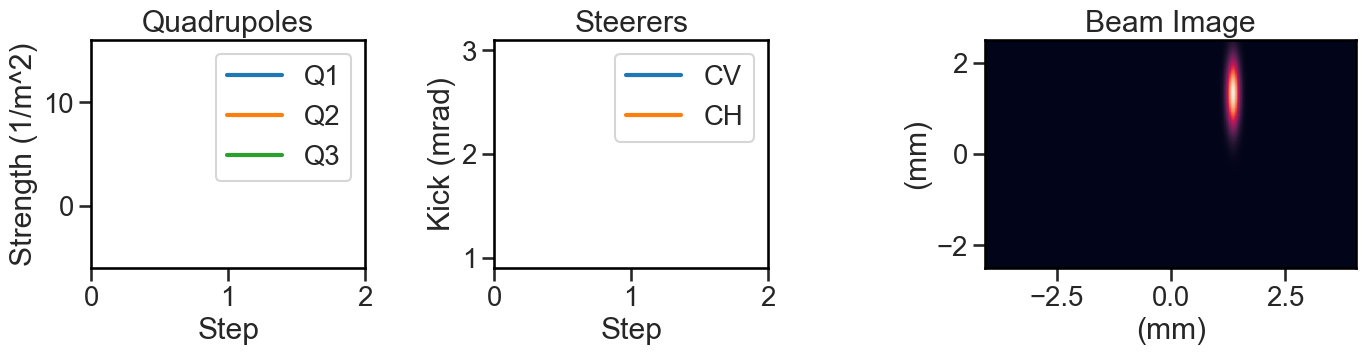

In [23]:
tb = [0,0,0,0]  # Change it
env = ARESEA(target_beam_mode="constant",target_beam_values=tb, magnet_init_mode="constant", magnet_init_values=[15,-5,1e-3,15,3e-3])
env = RescaleAction(env, -1, 1)  # Normalize the action space to [-1,1]^n
observation, _ = env.reset()
env.render()

Initial after reset


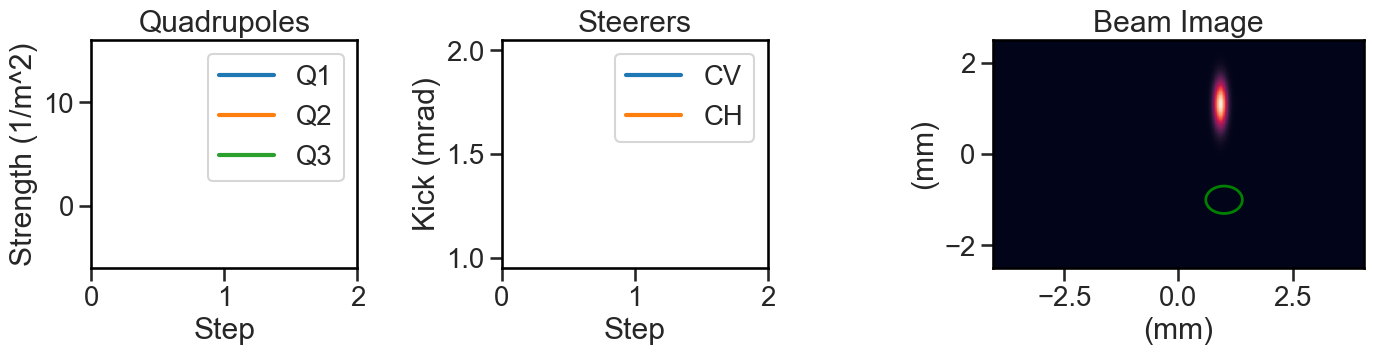

In [26]:
tb = [1e-3,4e-4,-1e-3,3e-4]  # Change it
env = ARESEA(target_beam_mode="constant",target_beam_values=tb, magnet_init_mode="constant", magnet_init_values=[15,-5,1e-3,5,2e-3])
env = RescaleAction(env, -1, 1)  # Normalize the action space to [-1,1]^n
observation, _ = env.reset()
print("Initial after reset")
env.render()

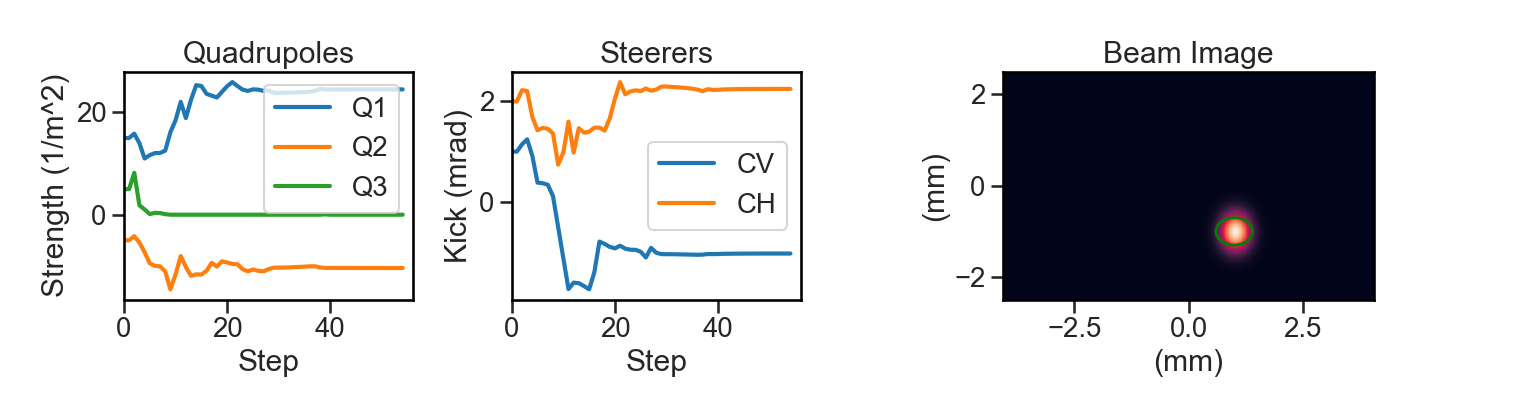

In [27]:
# Here we use the trick to contrain allowed action step size
opt_info = bayesian_optimize(env, last_observation=observation,n_steps=50,max_step_size=0.1,  show_plot=True, beta=0.2)
# Another advanced technique "Proximal biasing" uses soft step size limit
# opt_info = bayesian_optimize(env, last_observation=observation,n_steps=50,max_step_size=1,  show_plot=True, beta=0.2, proximal=torch.ones(5)*0.5)

#### Exercise 2.1: See the effect of the acquisition function

In [ ]:
### Exercise:

env = ARESEA(target_beam_mode="constant",target_beam_values=[])
observation, _ = env.reset()


### Feel free to change the value to beta, see how it impacts the optimization process; Or switch to aother acquisition fucntion
bayesian_optimize(env, observation, n_steps=50, acquisition="UCB",beta=2.0)  

---


## Summary

- Bayesian Optimization is a numerical _global_ optimization method for black-box functions.

- BO uses a _Gaussian process_ as a statistical surrogate model of the objective.
  - GP is characterized by its mean and covariance (kernel) function.
  - Hyperparamters can be dynamically fitted to the data.
  - Prior knowledge can be included for setting the priors.
- BO uses the _acquisition function_ to guide the optimziation
  - One should choose an acquisition suitable for the task.
  - Hyperparameters of the acquisition function also affects the optimization behaviour.
- BO is an __optimization__ method. It is not designed for _control_ task.

---

## Literature

Hopefully you have learned something about BO, if you want to try it yourself afterwards, below are some interesting resources.


### Publication: Various applications of BO in accelerator physics

- KARA, KIT: [Bayesian Optimization of the Beam Injection Process into a Storage Ring](https://arxiv.org/abs/2211.09504) Beam injection optimization using BO.
- LCLS, SLAC: [Bayesian optimization of FEL performance at LCLS](https://accelconf.web.cern.ch/ipac2016/doi/JACoW-IPAC2016-WEPOW055.html), [Bayesian Optimization of a Free-Electron Laser](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.124.124801) FEL performance tuning with quadrupoles
- LUX, DESY: [Bayesian Optimization of a Laser-Plasma Accelerator](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.126.104801) LPA tuning to improve bunch quality with laser energy, focus position, and gas flows.
- Central Laser Facility, Rutherfold UK: [Automation and control of laser wakefield accelerators using Bayesian optimization](https://www.nature.com/articles/s41467-020-20245-6), LWFA performance tuning with different objective functions
- PSI, SwissFEL: [Tuning particle accelerators with safety constraints using Bayesian optimization](https://doi.org/10.1103/PhysRevAccelBeams.25.062802) [Adaptive and Safe Bayesian Optimization in High Dimensions via One-Dimensional Subspaces](https://arxiv.org/abs/1902.03229) : BO with safety contraints to protect the machine
- SLAC, ANL: [Multiobjective Bayesian optimization for online accelerator tuning](https://journals.aps.org/prab/abstract/10.1103/PhysRevAccelBeams.24.062801), multiobjective optimization for accelerator tuning,[Turn-key constrained parameter space exploration for particle accelerators using Bayesian active learning](https://www.nature.com/articles/s41467-021-25757-3), Bayesian active learning for effcient exploration of the parameter space. [Differentiable Preisach Modeling for Characterization and Optimization of Particle Accelerator Systems with Hysteresis](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.128.204801) hysteris modelling with GP, and application of hysteresis-aware BO.

### Books and papers on Bayesian optimization in general

- C. E. Rasmussen and C. K.I. Williams, [Gaussian Processes for Machine Learning](https://gaussianprocess.org/gpml/): __the__ classic textbook of Gaussian process.
- Eric Brochu, [A Tutorial on Bayesian Optimization of Expensive Cost Functions, with Application to Active User Modeling and Hierarchical Reinforcement Learning](https://arxiv.org/abs/1012.2599): a comprehensive tutorial on Bayesian optimization with some application cases at that time (2010).
- Peter I. Frazier, [A Tutorial on Bayesian Optimization](https://arxiv.org/abs/1807.02811): a more recent (2018) tutorial paper covering the most important aspects of BO, and some advanced variants of BO (parallel, multi-fidelity, multi-task).


### Bayesian Optimization / Gaussian Process packages in python

Below is a incomplete selection of python packages for BO and GP, each with its own strength and drawback.

- [scikit-learn Gaussian processes](https://scikit-learn.org/stable/modules/gaussian_process.html#) : recommended for sklearn users, not as powerful as other packages.
- [GPyTorch](https://gpytorch.ai/) : a rather new package implemented natively in PyTorch, which makes it very performant. Also comes with a Bayesian optimization package [BOTorch](https://botorch.org/), offering a variety of different optimization methods (mult-objective, parallelization...). Both packages are being actively developed maintained; __recommended state-of-the-art tool for BO practitioners__.
- [GPflow](https://www.gpflow.org/) : a GP package implemented in TensorFlow, it also has a large community and is being actively maintained; The new BO package [Trieste](https://secondmind-labs.github.io/trieste) is built on it.
- [GPy](http://sheffieldml.github.io/GPy/) from the Sheffield ML group : A common/classic choice for building GP model, includes a lot of advanced GP variants; However in recent years it is not so actively maintained. It comes with the accompanying Bayesian optimization package [GPyOpt](https://github.com/SheffieldML/GPyOpt), for which the maintainance stoped since 2020.
- [Dragonfly] : a open-source BO package; offers also command line tool, easy to use if you are a practitioner. However if one has less freedom to adapt and expand the code.

C.f. the [wikipedia page](https://en.wikipedia.org/wiki/Comparison_of_Gaussian_process_software#Comparison_table) for a more inclusive table with GP packages for other languages.

### Other Resources

- Another similarly structured BO tutorial using the _scikit-learn_ GP package, given at the [2022 MT ARD ST3 ML Workshop](https://github.com/ansantam/2022-MT-ARD-ST3-ML-workshop)